# Hemodynamic correction

The hemodynamic correction is done by:

- High pass filtering the signal above 0.1 Hz and subtracting the mean
- Computing the regression coefficients between the 2 channels.
- Subtracting a scaled version of the temporal components of one channel to the other to obtain the corrected temporal components.


In [1]:
from wfield import *
from wfield import *

localdisk = '/mnt/dual/temp_folder/CSP23_20200226/'
fs = 30

U = np.load(pjoin(localdisk,'U.npy'))
SVT = np.load(pjoin(localdisk,'SVT.npy'))

tstart = time.time()

SVTcorr, rcoeffs, T = hemodynamic_correction(U, SVT, fs=fs,
                                             freq_lowpass=10)        

print('Done hemodynamic correction in {0} s '.format(time.time()-tstart))

np.save(pjoin(localdisk,'rcoeffs.npy'),rcoeffs)
np.save(pjoin(localdisk,'T.npy'),T)
np.save(pjoin(localdisk,'SVTcorr.npy'),SVTcorr)


Skipping lowpass on the violet channel.
Done hemodynamic correction in 83.55486965179443 s 


In [37]:
%gui qt5
# Prepare the interactive plot
from  wfield import *
localdisk = '/mnt/dual/temp_folder/CSP22_20200226/'
U = np.load(pjoin(localdisk,'Ua.npy'))
SVTcorr = np.load(pjoin(localdisk,'SVTcorr.npy'))

stack = SVDStack(U,SVTcorr)


In [38]:
# Run (this needs to be in a different cell than the above) 
plot = qtgraph_show_svd(stack)

/home/joao/lib/wfieldtools/wfield/utils_svd.py:26: RuntimeWarning: invalid value encountered in true_divide
  return (cov_pix/std_pix).reshape(self.dims)


#### Use the following for debugging

<IPython.core.display.Javascript object>


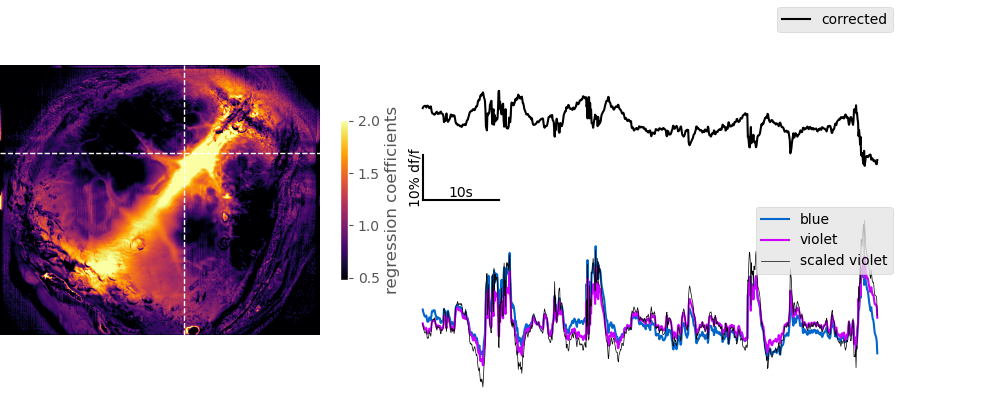

In [19]:

# def hemodynamic_correction_and_save(U,SVT,frame_rate = 30., nchannels = 2):
#                            highpass = True,
#                            nchunks = 1024,
#                            run_parallel = True
from wfield import *
frame_rate = 30.
output_folder = '/mnt/dual/temp_folder/CSP22_20200226/'
if output_folder is None:
    output_folder = os.path.abspath(os.path.curdir)
    print('Output not specified, using {0}'.format(output_folder))
    
U = np.load(pjoin(output_folder,'Ua.npy'))
SVT = np.load(pjoin(output_folder,'SVTa.npy'))
T = np.load(pjoin(output_folder,'T.npy'))
rcoeffs = np.load(pjoin(output_folder,'rcoeffs.npy'))
plot_summary_hemodynamics_dual_colors(rcoeffs,SVT,U,frame_rate=30.,outputdir = output_folder);
# SVTcorr, rcoeffs, T = hemodynamic_correction(U, SVT, fs=frame_rate)  

In [1]:
%matplotlib notebook
import pylab as plt
plt.matplotlib.style.use('ggplot')


In [ ]:

from wfield import np,pjoin

output_folder = '/mnt/dual/temp_folder/CSP22_20200226/'

U = np.load(pjoin(output_folder,'Ua.npy'))
SVT = np.load(pjoin(output_folder,'SVTa.npy'))
frame_rate = 30.


from wfield.ncaas import dual_color_hemodymamic_correction

SVTcorr = dual_color_hemodymamic_correction(U,SVT,
                                            frame_rate = frame_rate, 
                                            output_folder = output_folder);

Skipping lowpass on the violet channel.


<IPython.core.display.Javascript object>


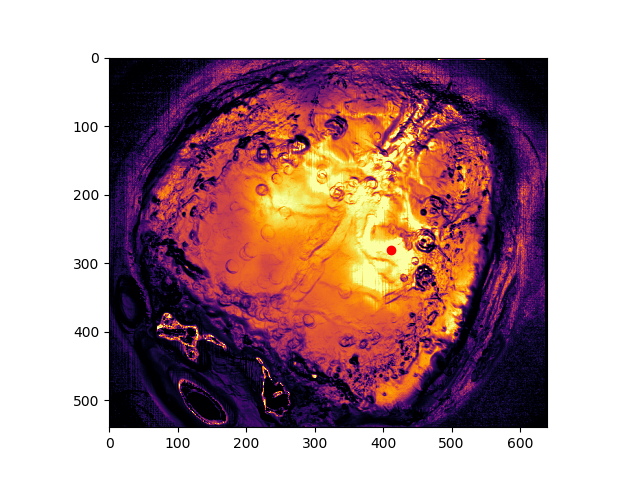

<IPython.core.display.Javascript object>


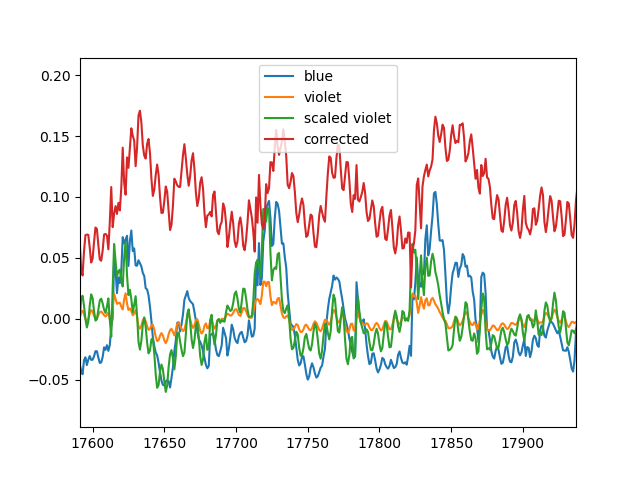

In [13]:
# def plot_summary_hemodynamics_dual_colors

%matplotlib notebook
# plots a random time
frame_rate = 60
k,nframes = SVT.shape
# gets 10 seconds of data
SVTa = SVT[:,0:nframes:2] 
SVTb = SVT[:,1:nframes:2]

SVTa = highpass(SVTa,.1,fs = frame_rate/2)
SVTb = highpass(SVTb,.1,fs = frame_rate/2)
SVTb = lowpass(SVTb,10.,fs = frame_rate/2)
SVTa = (SVTa.T - np.nanmean(SVTa,axis=1)).T.astype('float32')
SVTb = (SVTb.T - np.nanmean(SVTb,axis=1)).T.astype('float32')
SVTb_scaled = np.dot(T.T,SVTb)


projcorr = rcoeffs.reshape(U.shape[:2])
from skimage.filters import gaussian
p = projcorr[50:-50,50:-50] # to avoid edge artifacts
idx = np.unravel_index(np.argmax(gaussian(p,10)),
                       p.shape) + np.array([50,50])
plt.imshow(projcorr,clim = np.percentile(projcorr,[10,98]),cmap='inferno')
plt.plot(idx[1], idx[0],'ro')


Ya = np.mean(U[idx[0]:idx[0]+10,idx[1]:idx[1]+10,:].reshape([-1,k])@SVTa,axis=0)
Yb = np.mean(U[idx[0]:idx[0]+10,idx[1]:idx[1]+10,:].reshape([-1,k])@SVTb,axis=0)
Ybscaled = np.mean(U[idx[0]:idx[0]+10,idx[1]:idx[1]+10,:].reshape([-1,k])@SVTb_scaled,axis=0)
Ycorr =  np.mean(U[idx[0]:idx[0]+10,idx[1]:idx[1]+10,:].reshape([-1,k])@(SVTa[:,:]-SVTb_scaled[:,:]),axis=0)
# plt.imshow()
# plt.colorbar()
# projstd = np.std(Ycorr,axis=0)


plt.figure()
plt.plot(Ya[:],label = 'blue')
plt.plot(Yb[:],label = 'violet')
plt.plot(Ybscaled[:],label = 'scaled violet')
plt.plot(Ycorr[:]+.1,label = 'corrected')
plt.legend()

In [11]:
Ycorr.shape

(10, 41621)

In [20]:
from wfield import napari_show
napari_show(np.concatenate([Ya,Yb,
                           Ybscaled],axis = 2))


<IPython.core.display.Javascript object>


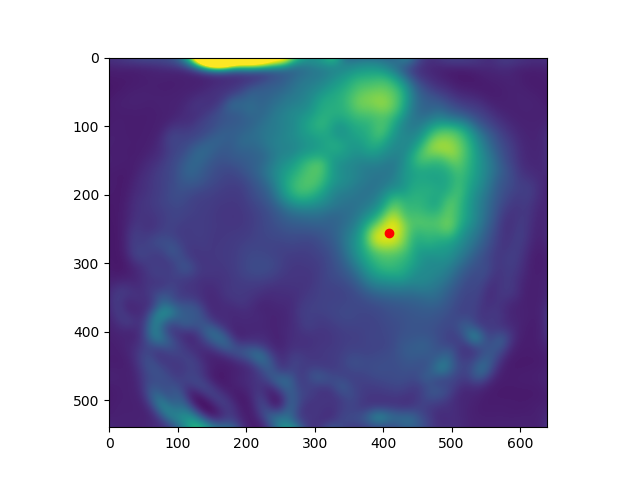

<IPython.core.display.Javascript object>


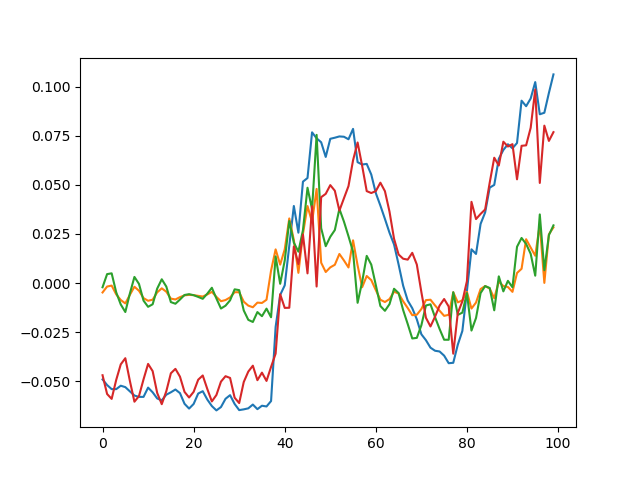

In [43]:
gaussian?